# 利用知识蒸馏进行教师学生模型训练程序 version 3.0
### 1. 程序说明
1.1. 原始cell程序将UNKNOWN类型作为已知分类，实际为未标注数据，程序做了修改，通过数据预处理，将数据集分为标注数据集和未标注数据集。  
1.2. 原来cell程序中，modality = 'both'时，二者取并集,共有102行,通过对其分类分析，每个分类大于15条样本的分类只有2个，因此原来的程序训练的实际为二分类问题, 这里将每个分类改为5来保留所有分类，
version 1.0 updated
1. 实现程序结构优化
2. 针对小样本(样本数量仅有102条)的问题，将min_cells_per_type修改为5，保留了所有分类。
3. 针对样本不均衡问题，利用bagging和stacking方法，对模型进行集成，实现模型融合，解决小样本不均衡问题，提高模型精度。
4. 通过训练教师模型，标注无标签数据，利用所标注的数据训练学生模型，将教师模型的输出作为学生模型的输入，实现知识蒸馏，提高模型精度。
version 2.0 updated
1. 针对小样本的不均衡问题，增加了欠采样处理函数，实现了SMOTE, SMOTEN, SMOTENC, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, RandomOverSampler, ADASYN等采样方法，教师模型准确度有较大提升。
2. 增加了部分绘图函数，实现可视化。
version 3.0 updated
1. 修改程序构架，将函数和常量统一移入utils.py文件中，方便统一调用。
### 2. 数据集说明
2.1. ephys数据集文件:382行，标题行1行，数据行381行，其中：标注数据313行，未标注数据68行；共42列，第0列为specimen_id索引列，特征列41列  
2.2. morph数据集文件:170行，标题行1行，数据行170行，其中：标注数据102行，未标注数据68行；共26列，第0列为specimen_id索引列，特征列25列  

## 1. Import Libraries

In [1]:
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor
import matplotlib.pyplot as plt
from utils import *

## 2. Program initialization
#### <font color='Red'>注意：缺失值补插和过采样在此处设置</font>  

In [2]:
taxonomy = 'Berg'                   # choose which taxonomy:        'Berg', 'SEA_AD' or 'Mouse'
cell_subset = 'Superficial'         # choose which cells:           'All', 'Superficial' or 'Deep'
modality = 'Ephys'                  # choose which modality:        'Both', 'Ephys' or 'Morph'
rowfilte = True                     # choose if you want to row filter: True or False
scaler_method = None                # choose your data format:      'standard','minmax','robust','normalizer','quantile'
impute_method = 'knn'                # choose which imputer:         None or 'knn' or 'liner' or 'Polynomial' or 'decisiontree':
oversample_method = 'random'            # choose which oversampler:      None or 'random' or 'smote' or 'smoten' or 'smotenc' or 'borderline' or 'adasyn' or 'svmsmote' or 'kmeans'

In [3]:
# 设置缺省参数
# min_num_features = 8              # minimum number of features left to classify (e.g. 5)
# threshold_percentile = 5          # minimum percentage a feature needs to contribute to accurate prediction (e.g. 5)
min_cells_per_type = 5              # minimum cells necessary in the training data per group/label/cell-type (e.g. 5 or 10)
null_threshold = 0.2                       # row filter null value threshold
test_size =0.20                     # test size for cross validation (e.g. 0.2)
#depth_threshold = 0.575            # choose depth threshold
#index_column = 'specimen_id'       # index column name
#label_column = 'label'             # label column name
#FREM3_list = ['Exc L2-3 LINC00507 FREM3']                                    # 需区分浅层和深层FREM3细胞的列表
#superficial_t_types = ['Exc L2 LAMP5 LTK', 'Exc L2-4 LINC00507 GLP2R', 'Exc L2-3 LINC00507 FREM3 superficial']
#deep_t_types = ['Exc L2-3 LINC00507 FREM3 deep', 'Exc L3-4 RORB CARM1P1', 'Exc L3-5 RORB COL22A1']
teacher_model_path = 'models\\Teacher\\'
student_model_path = 'models\\Student\\'
#random_state = 42

## 3. Data Loading
### 3.1 读取数据文件

In [4]:
# # Define the path to the files and read in the data
meta_data_path = Path("..\data\meta_data_withVU.csv")        # read the meta data file
ephys_path = Path("..\data\ephys_data_withVU.csv")           # read the ephys data file
morph_path = Path("..\data\morph_data_withVU.csv")           # read the morph data file
# Read in the data files
meta_data = pd.read_csv(meta_data_path, index_col=0) 
ephys_data = pd.read_csv(ephys_path, index_col=0)
morph_data = pd.read_csv(morph_path, index_col=0)
print('原始数据文件：')
print('ephys_dataset:', ephys_data.shape)
print('morph_dataset:', morph_data.shape)

原始数据文件：
ephys_dataset: (522, 35)
morph_dataset: (170, 25)


### 3.2 分离标注数据和非标注数据   
统一索引列和更新L23_depth_normalized列,根据taxonomy设置标签列,根据modality设置数据集的特征列,根据cell type过滤数据集样本(行)

In [5]:
labeled_data, unlabeled_data =  load_data_l23_depth_normalized(meta_data, ephys_data, morph_data, taxonomy = taxonomy, modality = modality, cell_subset = cell_subset)
print('--- Init Setup ---')
print('Cell_subset: ',cell_subset)
print('Modality:    ', modality)
print('Taxonomy:    ', taxonomy)
print('Labeled_data:    ', labeled_data.shape)
print('Unlabeled_data:  ', unlabeled_data.shape)

--- Init Setup ---
Cell_subset:  Superficial
Modality:     Ephys
Taxonomy:     Berg
Labeled_data:     (230, 37)
Unlabeled_data:   (209, 37)


#### 3.2.1 原始的分类数和每个分类的样本数

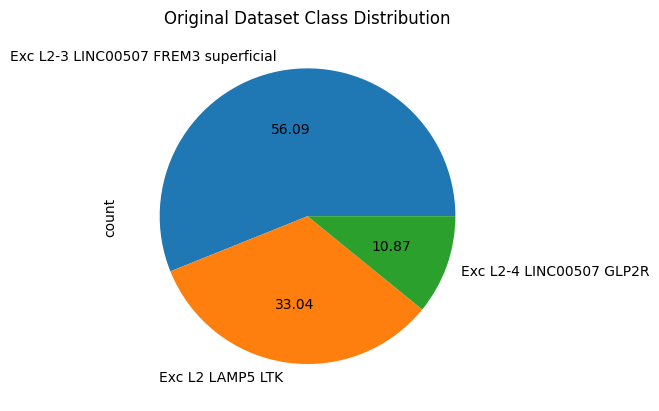

In [6]:
ax = labeled_data[LABEL_COLUMN].value_counts().plot.pie(autopct='%.2f')
ax.set_title("Original Dataset Class Distribution")
plt.show()

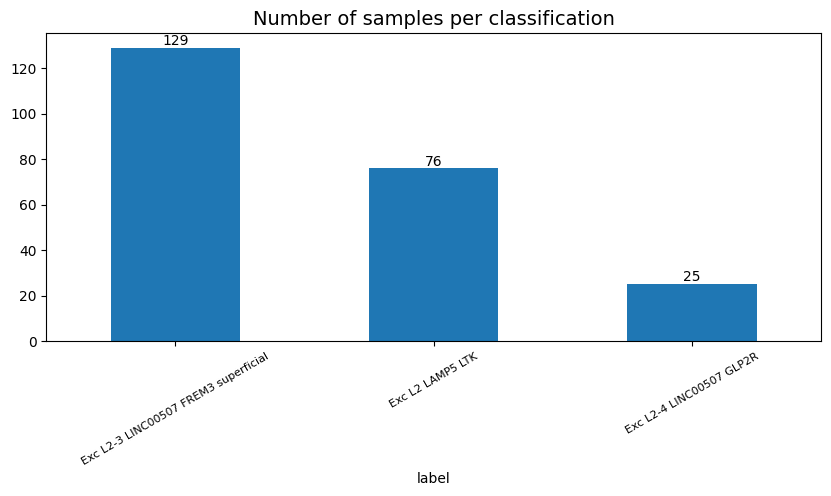

In [7]:
plt.figure(figsize=(10,4))
labeled_data[LABEL_COLUMN].value_counts().plot(kind='bar')
# 为条形图添加数值标签
plt.bar_label(plt.gca().containers[0])
plt.title('Number of samples per classification', fontsize=14)
plt.xticks(rotation=30,fontsize=8)
plt.show()

## 4 Data preprocessing 

### 4.1 行过滤 
根据每个分类最小样本数(min_cells_per_type)过滤数据集的样本(行)，根据每行空值数过滤。

In [8]:
if rowfilte:
    labeled_data = filter(labeled_data,min_cells_per_type=min_cells_per_type, threshold=null_threshold)

过滤后的分类数和每个分类的样本数绘图   
因为最少的几个分类为5、8、9，当min_cells_per_type>5时，分类会减少,这里绘图用于对比

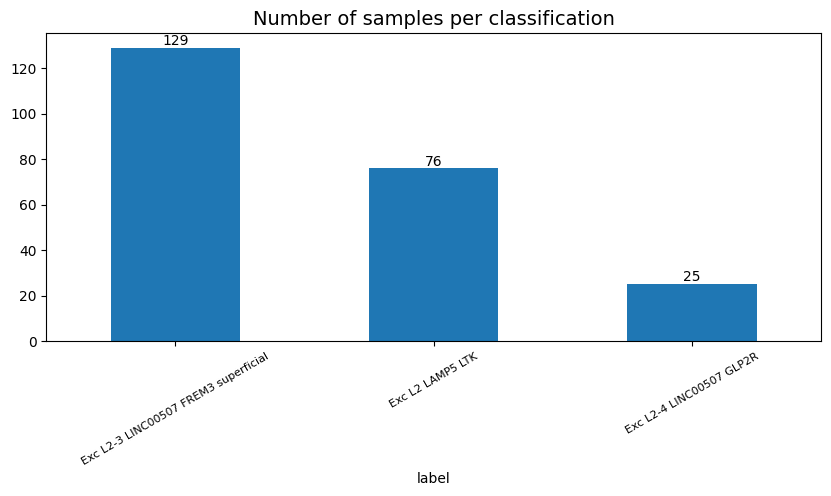

In [9]:
plt.figure(figsize=(10,4))
labeled_data[LABEL_COLUMN].value_counts().plot(kind='bar')
# 为条形图添加数值标签
plt.bar_label(plt.gca().containers[0])
plt.title('Number of samples per classification', fontsize=14)
plt.xticks(rotation=30,fontsize=8)
plt.show()

### 4.2 补插空值   
根据impute_method设置执行

#### 4.2.1 对label_data数据集补插缺失值

In [10]:
if impute_method:
    print('-------------------------------            Imputing Dataset            -------------------------------')
    print('1. Imputing Labeled Dataset')
    # 不包含标签列进行补插
    print('补插前标记数据集信息:')
    t_type_labels = labeled_data.iloc[:, -1].values
    print(labeled_data.info())
    labeled_data = impute(labeled_data.iloc[:,0:labeled_data.columns.size-1],method=impute_method)
    labeled_data[LABEL_COLUMN] = t_type_labels
    print('补插后标记数据集信息:')
    print(labeled_data.info())

-------------------------------            Imputing Dataset            -------------------------------
1. Imputing Labeled Dataset
补插前标记数据集信息:
<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, 541549258 to 811939096
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   input_resistance      230 non-null    float64
 1   sag                   230 non-null    float64
 2   VmatSag               230 non-null    float64
 3   vmbaseM               230 non-null    float64
 4   tau                   230 non-null    float64
 5   FAP_rheobase          230 non-null    float64
 6   FAP_num_APs           230 non-null    float64
 7   TS1_rheobase          230 non-null    float64
 8   TS1_num_APs           230 non-null    float64
 9   TS2_rheobase          230 non-null    float64
 10  TS2_num_APs           230 non-null    float64
 11  TS1_adp_index         201 non-null    float64
 12  TS2_adp_index         21

#### 4.2.2 对unlabel_data数据集补插 

In [11]:
if impute_method:
    print('2. Imputing Unlabeled Dataset')
    # 对unlabel_data数据集补插 
    print('补插前未标记数据集信息:')
    print(unlabeled_data.info())
    unlabeled_data = impute(unlabeled_data.iloc[:,0:unlabeled_data.columns.size-1],method=impute_method)
    unlabeled_data[LABEL_COLUMN] = np.nan
    print('补插后未标记数据集信息:')
    print(unlabeled_data.info())

2. Imputing Unlabeled Dataset
补插前未标记数据集信息:
<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 110000001 to H23.29.252.11.91.02
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   input_resistance      207 non-null    float64
 1   sag                   207 non-null    float64
 2   VmatSag               207 non-null    float64
 3   vmbaseM               209 non-null    float64
 4   tau                   200 non-null    float64
 5   FAP_rheobase          209 non-null    float64
 6   FAP_num_APs           209 non-null    float64
 7   TS1_rheobase          209 non-null    float64
 8   TS1_num_APs           208 non-null    float64
 9   TS2_rheobase          208 non-null    float64
 10  TS2_num_APs           208 non-null    float64
 11  TS1_adp_index         186 non-null    float64
 12  TS2_adp_index         196 non-null    float64
 13  FAP_threshold         209 non-null    float64
 14  FAP_peak    

### 4.3 标准化   
根据scaler_method设置执行

In [12]:
# 转换为numpy数组
data_array = labeled_data.iloc[:,0:labeled_data.columns.size-1].values              # transform the data to an array

# Check if data needs to be scoring
if scaler_method:
    print('-------------------------------             Scaling Dataset            -------------------------------')
    data_array = scale(data_array, scalemethod = scaler_method)                     # apply scoring method 


cell_ids_subset = labeled_data.index                                                # extract the cell IDs of the subset
# Create a list of features
feature_list = labeled_data.iloc[:,0:labeled_data.columns.size-1].keys().values
# normalized_depths = labeled_data['L23_depth_normalized'].values                     # extract normalized depth values
t_type_labels = labeled_data.iloc[:, -1].values                                     # extract t-type labels of the data subset
t_types_updated = np.unique(t_type_labels)
print('dataset rownum:',data_array.shape[0])
print('feature num:',len(feature_list))
print('feature list:',feature_list)
print('cell type num:',len(t_types_updated))
print('cell type list:',t_types_updated)

dataset rownum: 230
feature num: 36
feature list: ['input_resistance' 'sag' 'VmatSag' 'vmbaseM' 'tau' 'FAP_rheobase'
 'FAP_num_APs' 'TS1_rheobase' 'TS1_num_APs' 'TS2_rheobase' 'TS2_num_APs'
 'TS1_adp_index' 'TS2_adp_index' 'FAP_threshold' 'FAP_peak'
 'FAP_maxupstroke' 'FAP_maxdownstroke' 'FAP_halfwidth' 'FAP_avg_upstroke'
 'FAP_avg_downstroke' 'FAP_up_down_ratio' 'TS1_threshold'
 'TS1_maxupstroke' 'TS1_maxdownstroke' 'TS1_halfwidth' 'TS1_avg_upstroke'
 'TS1_avg_downstroke' 'TS1_up_down_ratio' 'TS2_threshold' 'TS2_peak'
 'TS2_maxupstroke' 'TS2_maxdownstroke' 'TS2_avg_upstroke'
 'TS2_avg_downstroke' 'TS2_up_down_ratio' 'L23_depth_normalized']
cell type num: 3
cell type list: ['Exc L2 LAMP5 LTK' 'Exc L2-3 LINC00507 FREM3 superficial'
 'Exc L2-4 LINC00507 GLP2R']


### 4.4 训练集测试集数据拆分

In [13]:
# Split the data into a training and test dataset
X_train, X_test, y_train, y_test = train_test_split(data_array, t_type_labels, test_size=test_size, stratify=t_type_labels, random_state=RANDOM_STATE)

### 4.5 过采样解决样本不平衡问题
利用imblearn库的SMOTE、SMOTEENN、ADASYN和KMeansSMOTE算法, 解决样本不平衡问题，过采样，需要补插缺失值，否则会报错。 

In [14]:
# 组合X_train数据为dataframe，未包含label列
train_data= pd.DataFrame(data = X_train, columns = feature_list)

if oversample_method:
    # 过采样的数据集不能有空值
    # 当程序未设置插值方法,这里使用默认的knn方法,否则使用设定的插值方法
    if impute_method:
        train_data = impute(train_data, method = impute_method, random_state = RANDOM_STATE)
    else:
        train_data = impute(train_data, random_state = RANDOM_STATE)
    # 进行过采样
    X_train, y_train = oversampler(train_data.values, y_train, method = oversample_method)    
    train_data= pd.DataFrame(data = X_train, columns = feature_list)
train_data[LABEL_COLUMN] = y_train

Save Figure:Oversampled Dataset Number of samples per classification


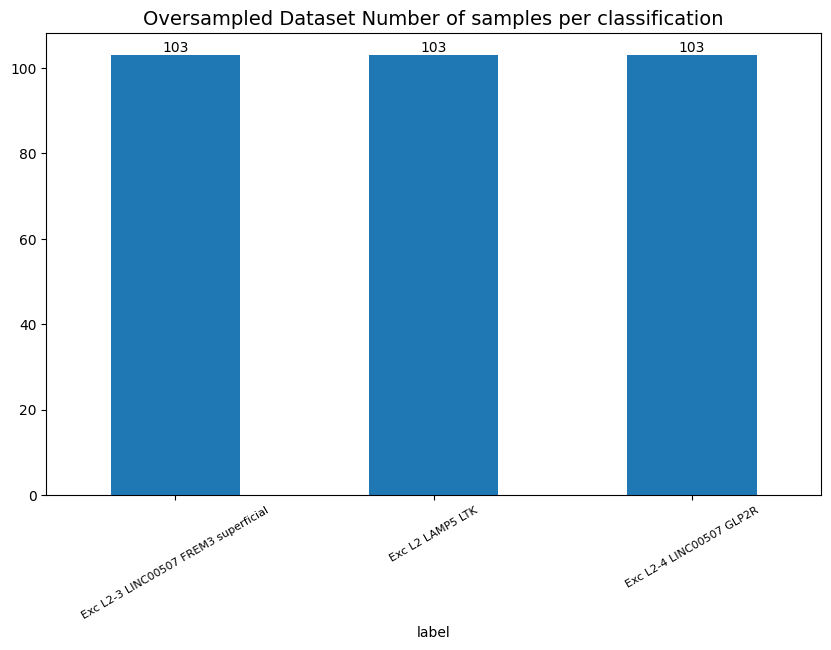

In [15]:
if oversample_method:    
    # 绘制过采样后的训练集的每分类的数量
    plt.figure(figsize=(10,6))
    train_data[LABEL_COLUMN].value_counts().plot(kind='bar')
    # 为条形图添加数值标签
    plt.bar_label(plt.gca().containers[0])
    figtitle = 'Oversampled Dataset Number of samples per classification'
    plt.title(figtitle, fontsize=14)
    plt.xticks(rotation=30,fontsize=8)
    print(f'Save Figure:{figtitle}')
    plt.show()   


Save Figure:Over-sampled Dataset Class Distribution


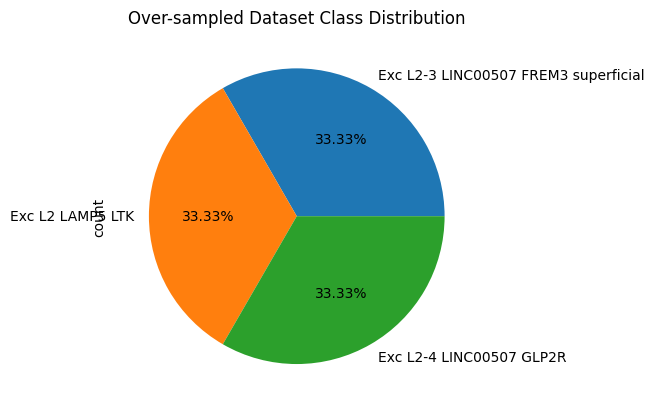

In [16]:
if oversample_method:  
    ax = train_data[LABEL_COLUMN].value_counts().plot.pie(autopct='%.2f%%')
    figtitle = 'Over-sampled Dataset Class Distribution'
    ax.set_title(figtitle)
    print(f'Save Figure:{figtitle}')
    plt.show()

### 4.6 生成测试数据

In [17]:
test_data_nolabel = pd.DataFrame(data = X_test, columns = feature_list)
test_data = test_data_nolabel.copy()
test_data[LABEL_COLUMN] = pd.DataFrame(y_test, columns = [LABEL_COLUMN])
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   input_resistance      46 non-null     float64
 1   sag                   46 non-null     float64
 2   VmatSag               46 non-null     float64
 3   vmbaseM               46 non-null     float64
 4   tau                   46 non-null     float64
 5   FAP_rheobase          46 non-null     float64
 6   FAP_num_APs           46 non-null     float64
 7   TS1_rheobase          46 non-null     float64
 8   TS1_num_APs           46 non-null     float64
 9   TS2_rheobase          46 non-null     float64
 10  TS2_num_APs           46 non-null     float64
 11  TS1_adp_index         46 non-null     float64
 12  TS2_adp_index         46 non-null     float64
 13  FAP_threshold         46 non-null     float64
 14  FAP_peak              46 non-null     float64
 15  FAP_maxupstroke       46 

#### 4.6.1 test数据集按分类的分布

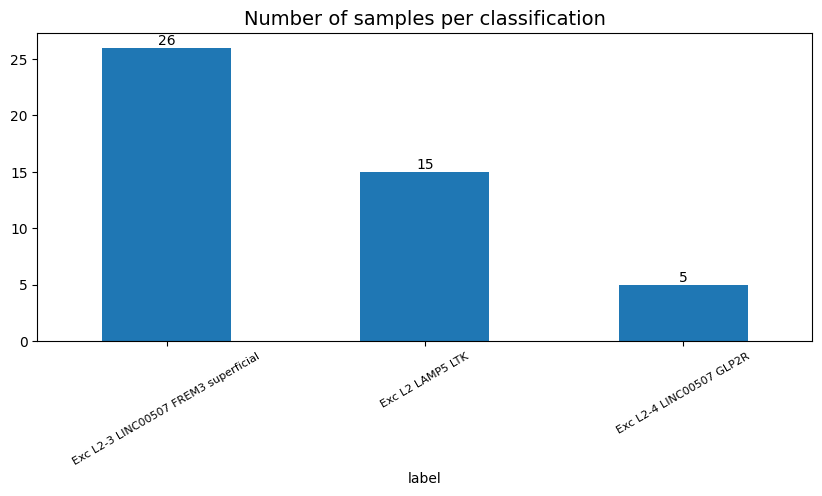

In [18]:
plt.figure(figsize=(10,4))
test_data[LABEL_COLUMN].value_counts().plot(kind='bar')
# 为条形图添加数值标签
plt.bar_label(plt.gca().containers[0])
plt.title('Number of samples per classification', fontsize=14)
plt.xticks(rotation=30,fontsize=8)
plt.show()

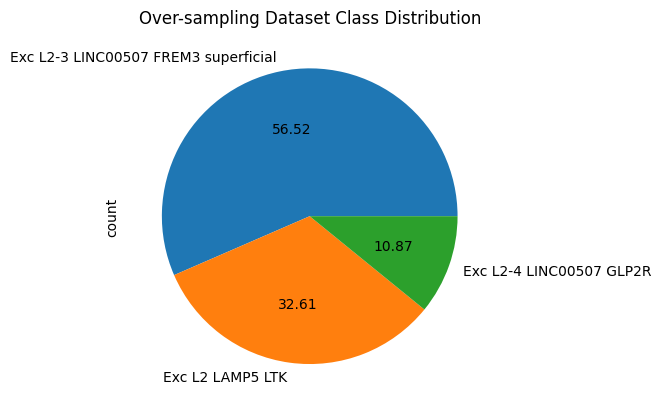

In [19]:
ax = test_data[LABEL_COLUMN].value_counts().plot.pie(autopct='%.2f')
ax.set_title("Over-sampling Dataset Class Distribution")
plt.show()

## 5. teacher model training

### 5.1 训练教师模型

**待确认的问题：**  
**1. 标准化处理是否自动进行有待确认，测试发现是否进行标准化似乎结果一致**。     
**2. 训练教师模型是否需要拆分出测试集，拆分后参与训练的数据减少会影响训练的结果，对于教师学生模型这种模式，需要通过教师模型预测未标注数据集，然后利用预测结果去训练学生模型，再利用学生模型学习教师模型，最终利用蒸馏得到的学生模型对标注数据集进行评估，因此开始拆分出测试集的必要性有待确认。**  

经测试发现数据集无需进行空值补插，框架自动进行特征工程、空值补插等操作。   
* Stage 1 Generators:    
    * Fitting AsTypeFeatureGenerator...  
* Stage 2 Generators:  
    * Fitting FillNaFeatureGenerator...  
* Stage 3 Generators:  
	* Fitting IdentityFeatureGenerator...  
* Stage 4 Generators:  
	* Fitting DropUniqueFeatureGenerator...  
* Stage 5 Generators:  
	* Fitting DropDuplicatesFeatureGenerator...  
因此可以直接进行训练和测试。  

模型的精度的选择：
关于训练后模型的命名规则详见：https://auto.gluon.ai/stable/api/autogluon.tabular.models.html  
参数的设置，增加训练时间的一般都会增加输出精度
* time_limit : 模型训练的最长等待时间，通常不设置  
* eval_metric: 指定评价指标例如，AUC还是精度等  
    * ‘f1’ (for binary classification), 
    * ‘roc_auc’ (for binary classification), 
    * ‘log_loss’ (for classification), ‘
    * ‘mean_absolute_error’ (for regression),
    * ‘median_absolute_error’ (for regression)
* presets： 默认为’medium_quality_faster_train’, 可以按medium_quality good_quality high_quality best_quality的顺序测试，找到适合的模型。折中的办法就是：presets=[‘good_quality’, ‘optimize_for_deployment’]。Available Presets: [‘best_quality’, ‘high_quality’, ‘good_quality’, ‘medium_quality’, ‘optimize_for_deployment’, ‘interpretable’, ‘ignore_text’]  
    * presets='best_quality'   : Maximize accuracy. Default time_limit=3600.  利用bagging/staking,准确度高但是运行时间长。
	* presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.  
	* presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.  
	* presets='medium_quality' : Fast training time, ideal for initial prototyping. 选择的算法运行时间较短，但准确率会差一点。 
目测presets='good_quality'以上时,缺省会采用stacking/bagging算法。关于模型的stacking/bagging算法，详见：https://www.jianshu.com/p/50bc90f87a05和https://blog.csdn.net/ueke1/article/details/137190677  
* Tuning_data: 这个作为验证集数据的参数，官网建议如果没有特别的理由时不加，让机器自己从训练集中分割出一小部分验证集，这边值得一提的是机器还能自己根据数据使用分层抽样等，可以说是非常人性化了。
* holdout_frac：这个参数指定从训练集出分割出多少比例的验证集
* num_bag_folds = 5-10，这个应该是类似k倍交叉验证，会增加训练时间
* num_stack_levels = 1-3，stacking 水平
* num_bag_sets:减少方差，但是增加训练时间  
**详细说明见下列连接：**  
**https://auto.gluon.ai/stable/api/autogluon.tabular.TabularPredictor.html**  
**https://auto.gluon.ai/stable/api/autogluon.tabular.TabularPredictor.fit.html**     

<font color='red'>可以设置num_bag_folds，num_stack_levels的值，并在fit函数中应用，来空值bagging和stacking</font>  
<font color='red'>设置k折交叉验证，需设置auto_stack为True和dynamic_stacking为True,并在ds_arg中设置参数才起作用</font>  


In [20]:
#设置训练精度
presets='high_quality'
eval_metric = 'accuracy'
verbosity = 2
time_limit = 3600
auto_stack=True
# bagging的折数,缺省好像未8
num_bag_folds=8
# stacking的级别
num_stack_levels=1
# n折交叉验证,设置auto_stack为True和dynamic_stacking为True
num_bag_sets=1
dynamic_stacking = True
# n_fold为交叉验证折数,n_repeats为交叉验证重复次数
ds_args = {
    'validation_procedure': 'cv',
    'n_folds': 5,
    'n_repeats': 1,
}
# 模型的保存路径，详细的模型命名规则见：https://auto.gluon.ai/stable/api/autogluon.tabular.models.html
save_path = teacher_model_path + presets + datetime.datetime.now().strftime("-%Y%m%d-%H%M%S")

# 开始训练
predictor = TabularPredictor(label=LABEL_COLUMN, verbosity=verbosity,eval_metric=eval_metric, path=save_path, log_to_file=True,log_file_path='auto')
if auto_stack and dynamic_stacking:
    predictor.fit(train_data, presets=presets, time_limit=time_limit, auto_stack=auto_stack, num_bag_folds=num_bag_folds, 
                        num_stack_levels=num_stack_levels, num_bag_sets=num_bag_sets,dynamic_stacking=dynamic_stacking, ds_args=ds_args)
elif auto_stack and not dynamic_stacking:
    predictor.fit(train_data, presets=presets, time_limit=time_limit, auto_stack=auto_stack, num_bag_folds=num_bag_folds,
                        num_stack_levels=num_stack_levels, num_bag_sets=num_bag_sets)
elif not auto_stack and dynamic_stacking:
    predictor.fit(train_data, presets=presets, time_limit=time_limit, auto_stack=auto_stack, dynamic_stacking=dynamic_stacking, ds_args=ds_args)
else:
    predictor.fit(train_data, presets=presets, time_limit=time_limit)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
Memory Avail:       9.99 GB / 15.92 GB (62.8%)
Disk Space Avail:   312.07 GB / 931.51 GB (33.5%)
Presets specified: ['high_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will 

#### 将基础信息写入文件保存

In [21]:
# 在模型目录中写入程序运行信息和数据预处理的基础信息
with open(save_path + '/model_info.txt', 'w') as f:
    f.writelines('--- Program Setup Info ---')
    f.writelines(f'\nmin_cells_per_type:{min_cells_per_type}')
    f.writelines(f'\ncell_subset:  {cell_subset}')
    f.writelines(f'\nmodality:     {modality}')
    f.writelines(f'\ntaxonomy:     {taxonomy}')
    f.writelines(f'\ndataset:      {labeled_data.shape}')
    f.writelines(f'\ntrain_data:   {X_train.shape}')
    f.writelines(f'\ntrain_label:  {np.unique(y_train)}')
    f.writelines(f'\ntest_data:    {X_test.shape}')
    f.writelines(f'\ntest_label:   {np.unique(y_test)}')
    f.writelines(f'\npresets:      {presets}')
    f.writelines('\n--- End of Program Setup Info ---')

#### 加载保存的模型的方法

In [22]:
# 加载以前训练结果，可用于查看以前的参数和使用以前训练的模型进行预测
#predictor_path = "models\Teacher\medium_quality-20241008-171554"
#predictor = TabularPredictor.load(predictor_path)

#### 显示训练结果信息

In [23]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)
print("Best Model:", predictor.model_best)
result = predictor.fit_summary(show_plot=True)

AutoGluon infers problem type is:  multiclass
AutoGluon identified the following types of features:
('float', []) : 36 | ['input_resistance', 'sag', 'VmatSag', 'vmbaseM', 'tau', ...]
Best Model: LightGBM_BAG_L2_FULL
*** Summary of fit() ***
Estimated performance of each model:
                                model  score_val eval_metric  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0                     LightGBM_BAG_L2   0.941748    accuracy       9.456595  1324.130895                0.028830           7.703694            2      False        112
1                 WeightedEnsemble_L3   0.941748    accuracy       9.457593  1324.386525                0.000998           0.255630            3      False        128
2                LightGBMLarge_BAG_L2   0.941748    accuracy       9.471454  1348.143882                0.043688          31.716681            2      False        120
3                LightGBM_r131_BAG_L2   0.938511    ac

d:\pythonprj\env\tcell-QkBhXdaq-py3.11\Lib\site-packages\autogluon\core\utils\plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


### 5.2 利用教师模型对测试集预测

#### Best model 预测与实际对比

In [24]:
from sklearn.metrics import classification_report
y_pred = predictor.predict(test_data_nolabel)#,model=predictor.model_best)
print(predictor.model_best)
results = pd.concat([y_pred, pd.DataFrame(y_test, columns = [LABEL_COLUMN])], axis=1)
results.columns=['predicted', 'actual']
# 打印每个类的精确度，召回率，F1值, 由于样本量较少,会出现被0除, 计算结果为0，但会出现警告错误：
# UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. 
# Use `zero_division` parameter to control this behavior._warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
print(classification_report(results['actual'], results['predicted'], target_names=t_types_updated))
# 输出预测值与实际值对比
#results

LightGBM_BAG_L2_FULL
                                      precision    recall  f1-score   support

                    Exc L2 LAMP5 LTK       0.60      0.40      0.48        15
Exc L2-3 LINC00507 FREM3 superficial       0.64      0.88      0.74        26
            Exc L2-4 LINC00507 GLP2R       0.00      0.00      0.00         5

                            accuracy                           0.63        46
                           macro avg       0.41      0.43      0.41        46
                        weighted avg       0.56      0.63      0.58        46



d:\pythonprj\env\tcell-QkBhXdaq-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\pythonprj\env\tcell-QkBhXdaq-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\pythonprj\env\tcell-QkBhXdaq-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

### 利用SNS和Matplotlib绘制混淆矩阵

#### 利用matplotlib的matshow函数绘制混淆矩阵    

[[ 6  9  0]
 [ 3 23  0]
 [ 1  4  0]]


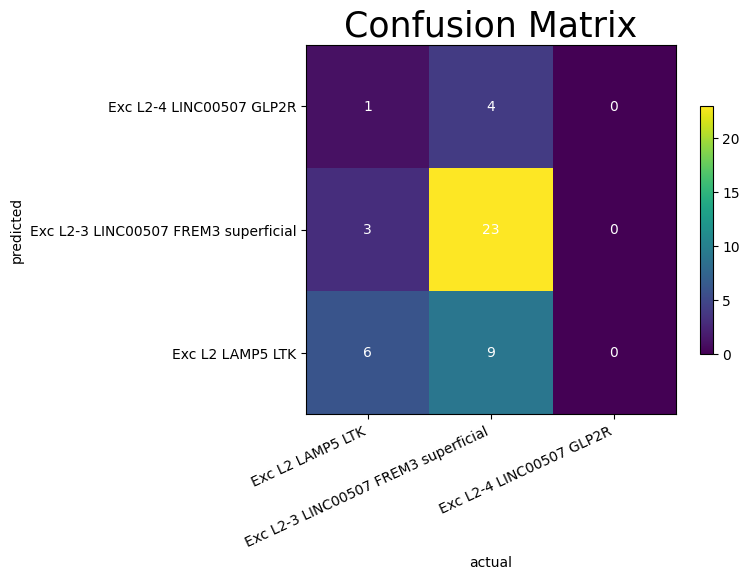

In [25]:
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(results['actual'], results['predicted'], labels=t_types_updated)
print(cfm)
#imshow和matshow二者不同在于横轴一个在上方一个在下方，还有就是plt.matshow()显示图片可以连续使用，
# 但是plt.imshow()想要显示多张图片必须每次都新建一个图plt.figure()或者使用plt.subplots()
ax = plt.imshow(cfm, origin ='lower') 

plt.title("Confusion Matrix",fontsize=25)
plt.colorbar(ax.colorbar, fraction=0.025)
plt.xlabel('actual')
plt.ylabel('predicted')
# 设置刻度字体大小
plt.xticks(np.arange(len(t_types_updated)),labels=t_types_updated, rotation=25,  ha="right",fontsize=10)
plt.yticks(np.arange(len(t_types_updated)),labels=t_types_updated, fontsize=10)
#plt.set_xticklabels(t_types_updated)
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        plt.text(j, i, f'{cfm[i, j]:.0f}', ha='center', va='center', color='white')
plt.show()

#### 显示各个类别预测概率

In [26]:
y_pred_proba = predictor.predict_proba(test_data)
y_pred_proba

,Exc L2 LAMP5 LTK,Exc L2-3 LINC00507 FREM3 superficial,Exc L2-4 LINC00507 GLP2R
0,0.339407,0.464418,0.196175
1,0.207652,0.619546,0.172802
2,0.240375,0.535233,0.224392
3,0.267309,0.515105,0.217586
4,0.215946,0.621756,0.162298
5,0.167669,0.679573,0.152759
6,0.300176,0.543016,0.156808
7,0.211383,0.629714,0.158903
8,0.215254,0.580632,0.204114
9,0.555338,0.291752,0.152910


#### 模型解释：特征重要性

In [27]:
print(predictor.feature_importance(test_data))

Computing feature importance via permutation shuffling for 36 features using 46 rows with 5 shuffle sets...
	455.7s	= Expected runtime (91.14s per shuffle set)
	31.17s	= Actual runtime (Completed 5 of 5 shuffle sets)


                      importance    stddev   p_value  n  p99_high   p99_low
TS1_maxupstroke         0.026087  0.009722  0.001941  5  0.046105  0.006069
TS2_peak                0.017391  0.018188  0.049650  5  0.054841 -0.020059
TS1_avg_downstroke      0.017391  0.023814  0.088904  5  0.066425 -0.031642
TS1_adp_index           0.013043  0.011907  0.035242  5  0.037560 -0.011473
tau                     0.008696  0.011907  0.088904  5  0.033212 -0.015821
TS2_avg_downstroke      0.008696  0.011907  0.088904  5  0.033212 -0.015821
TS2_adp_index           0.004348  0.023814  0.352000  5  0.053381 -0.044686
FAP_rheobase            0.004348  0.009722  0.186950  5  0.024366 -0.015670
FAP_halfwidth           0.004348  0.018188  0.310654  5  0.041798 -0.033102
FAP_maxdownstroke       0.000000  0.015372  0.500000  5  0.031651 -0.031651
TS1_threshold           0.000000  0.015372  0.500000  5  0.031651 -0.031651
FAP_num_APs             0.000000  0.015372  0.500000  5  0.031651 -0.031651
TS2_threshol

#### 评估教师模型性能    
<font color='Red'>这里也可以查看混淆矩阵</font>

In [28]:
# Evaluate the predictor (optional)
eval_result = predictor.evaluate(test_data, display=False, detailed_report=True)
print(predictor.model_best)
eval_result

LightGBM_BAG_L2_FULL


d:\pythonprj\env\tcell-QkBhXdaq-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\pythonprj\env\tcell-QkBhXdaq-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\pythonprj\env\tcell-QkBhXdaq-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

{'accuracy': 0.6304347826086957,
 'balanced_accuracy': 0.42820512820512824,
 'mcc': 0.2679242057348946,
 'confusion_matrix':                                       Exc L2 LAMP5 LTK  \
 Exc L2 LAMP5 LTK                                     6   
 Exc L2-3 LINC00507 FREM3 superficial                 3   
 Exc L2-4 LINC00507 GLP2R                             1   
 
                                       Exc L2-3 LINC00507 FREM3 superficial  \
 Exc L2 LAMP5 LTK                                                         9   
 Exc L2-3 LINC00507 FREM3 superficial                                    23   
 Exc L2-4 LINC00507 GLP2R                                                 4   
 
                                       Exc L2-4 LINC00507 GLP2R  
 Exc L2 LAMP5 LTK                                             0  
 Exc L2-3 LINC00507 FREM3 superficial                         0  
 Exc L2-4 LINC00507 GLP2R                                     0  ,
 'classification_report': {'Exc L2 LAMP5 LTK': {'precis

#### 查看不同模型的评估指标
**注:**
**‘f1’, ‘recall’, ‘precision’, ‘roc_auc’ 是针对二分类问题的，多分类使用‘f1_macro’, ‘f1_micro’, ‘f1_weighted’, ‘precision_macro’, ‘precision_micro’, ‘precision_weighted’, ‘recall_macro’, ‘recall_micro’, ‘recall_weighted’**

options for classification:  
[‘accuracy’, ‘balanced_accuracy’, ‘f1’, ‘f1_macro’, ‘f1_micro’, ‘f1_weighted’, ‘roc_auc’, ‘roc_auc_ovo_macro’, ‘average_precision’, ‘precision’, ‘precision_macro’, ‘precision_micro’, ‘precision_weighted’, ‘recall’, ‘recall_macro’, ‘recall_micro’, ‘recall_weighted’, ‘log_loss’, ‘pac_score’]  

Options for regression:  
[‘root_mean_squared_error’, ‘mean_squared_error’, ‘mean_absolute_error’, ‘median_absolute_error’, ‘mean_absolute_percentage_error’, ‘r2’, ‘symmetric_mean_absolute_percentage_error’]  

In [29]:
# Get leaderboard of models (optional)
leaderboard = predictor.leaderboard(test_data,extra_info=False, silent=True)

# Access predictions and evaluation results as needed
print(leaderboard)
#leaderboard.to_csv('leaderboard_medium.csv')

                                model  score_test  score_val eval_metric  \
0    NeuralNetFastAI_r172_BAG_L1_FULL    0.760870        NaN    accuracy   
1    NeuralNetFastAI_r194_BAG_L1_FULL    0.739130        NaN    accuracy   
2    NeuralNetFastAI_r191_BAG_L2_FULL    0.739130        NaN    accuracy   
3             CatBoost_r5_BAG_L1_FULL    0.717391        NaN    accuracy   
4           LightGBM_r196_BAG_L1_FULL    0.717391        NaN    accuracy   
..                                ...         ...        ...         ...   
251        NeuralNetFastAI_r65_BAG_L1         NaN   0.844660    accuracy   
252       NeuralNetFastAI_r160_BAG_L1         NaN   0.841424    accuracy   
253       NeuralNetFastAI_r111_BAG_L1         NaN   0.838188    accuracy   
254       NeuralNetFastAI_r143_BAG_L1         NaN   0.812298    accuracy   
255               LightGBM_r96_BAG_L1         NaN   0.796117    accuracy   

     pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  \
0          0

## 6. 利用教师模型预测未标记数据集

In [30]:
y_pred = predictor.predict(unlabeled_data.iloc[:,0:-1])
unlabeled_data.iloc[:,-1] = y_pred
y_pred


C:\Users\frank\AppData\Local\Temp\ipykernel_13848\2002465791.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      Exc L2-3 LINC00507 FREM3 superficial
1      Exc L2-3 LINC00507 FREM3 superficial
2      Exc L2-3 LINC00507 FREM3 superficial
3      Exc L2-3 LINC00507 FREM3 superficial
4      Exc L2-3 LINC00507 FREM3 superficial
                       ...                 
204    Exc L2-3 LINC00507 FREM3 superficial
205    Exc L2-3 LINC00507 FREM3 superficial
206    Exc L2-3 LINC00507 FREM3 superficial
207    Exc L2-3 LINC00507 FREM3 superficial
208    Exc L2-3 LINC00507 FREM3 superficial
Name: label, Length: 209, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  unlabeled_data.iloc[:,-1] = y_pred


0      Exc L2-3 LINC00507 FREM3 superficial
1      Exc L2-3 LINC00507 FREM3 superficial
2      Exc L2-3 LINC00507 FREM3 superficial
3      Exc L2-3 LINC00507 FREM3 superficial
4      Exc L2-3 LINC00507 FREM3 superficial
                       ...                 
204    Exc L2-3 LINC00507 FREM3 superficial
205    Exc L2-3 LINC00507 FREM3 superficial
206    Exc L2-3 LINC00507 FREM3 superficial
207    Exc L2-3 LINC00507 FREM3 superficial
208    Exc L2-3 LINC00507 FREM3 superficial
Name: label, Length: 209, dtype: object

### 查看预测概率

In [31]:
y_pred_proba = predictor.predict_proba(unlabeled_data.iloc[:,0:-1])
y_pred_proba 

,Exc L2 LAMP5 LTK,Exc L2-3 LINC00507 FREM3 superficial,Exc L2-4 LINC00507 GLP2R
0,0.215953,0.621776,0.162271
1,0.212822,0.624187,0.162991
2,0.198933,0.643389,0.157678
3,0.189562,0.646721,0.163717
4,0.267574,0.585454,0.146972
...,...,...,...
204,0.277082,0.474728,0.248189
205,0.232687,0.589155,0.178158
206,0.200341,0.640896,0.158763
207,0.268510,0.515822,0.215668


#### 观察unlabel数据预测概率的分布情况

<Axes: >

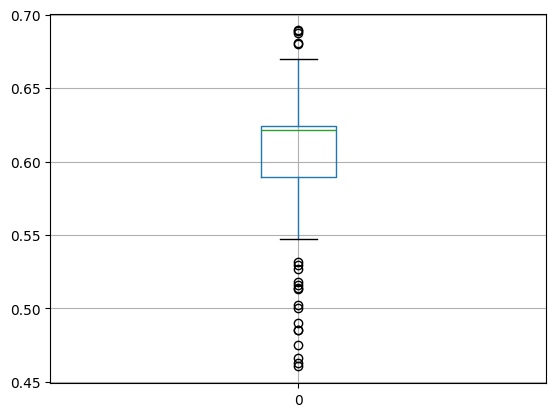

In [32]:
y_pred_proba.max(axis=1).sort_values().to_frame().boxplot()

#### 过滤unlabeled数据, 用于知识蒸馏

In [33]:
# 如果使用descibe的方式过滤可取以下值
proba_threshold = '25%' # '25%', '50%', '75%', 'mean'
idx_filted = y_pred_proba.max(axis=1)[y_pred_proba.max(axis=1)>=y_pred_proba.max(axis=1).describe()[proba_threshold]].index
# 如果使用median函数计算的方式过滤使用以下方法
# idx_filted = y_pred_proba.max(axis=1)[y_pred_proba.max(axis=1)>=y_pred_proba.max(axis=1).median()].index
#proba_list_75=y_pred_proba.max(axis=1)[y_pred_proba.max(axis=1)>y_pred_proba.max(axis=1).describe()['75%']]
#proba_list_50_25=y_pred_proba.max(axis=1)[proba_list.between(y_pred_proba.max(axis=1).describe()['25%'],y_pred_proba.max(axis=1)<y_pred_proba.max(axis=1).describe()['50%'])]
#idx_filted =pd.concat([proba_list_75,proba_list_50_25]).index


new_unlabeled_data=pd.concat([unlabeled_data.loc[idx_filted,:],unlabeled_data[unlabeled_data.iloc[:,-1]!='Exc L2-3 LINC00507 FREM3 superficial']])

new_unlabeled_data.shape

(157, 37)

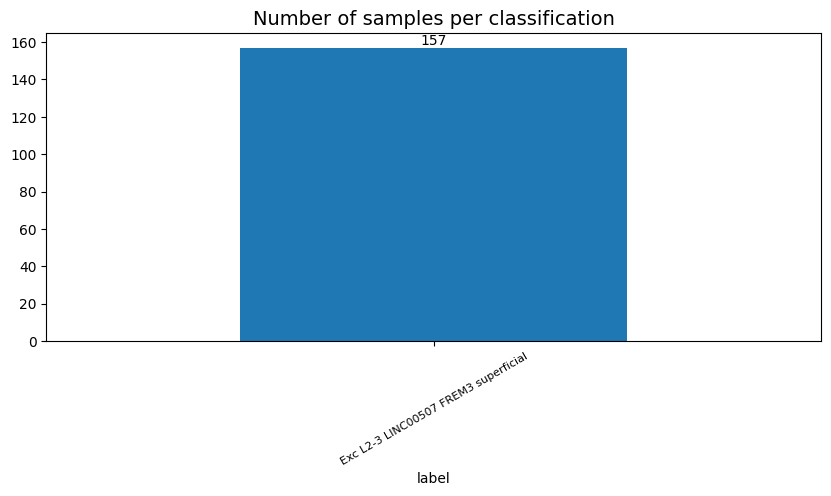

In [34]:
plt.figure(figsize=(10,4))
new_unlabeled_data[LABEL_COLUMN].value_counts().plot(kind='bar')
# 为条形图添加数值标签
plt.bar_label(plt.gca().containers[0])
plt.title('Number of samples per classification', fontsize=14)
plt.xticks(rotation=30,fontsize=8)
plt.show()

## 8.利用训练的教师模型和未标注的数据集蒸馏学生模型
**待确认的问题：** 
**1.teacher_preds参数的含义有待确认**  
**2.augment_method参数对于训练结果的影响，需要实验去确认,关于munge参数的内容，可阅读https://www.cs.cornell.edu/~caruana/compression.kdd06.pdf**  
**3.Knowledge Distillation in AutoMM这篇文章（见参考信息2）的调用方法与此不同，有待测试**
PARAMETERS:  
1. train_data (str or or , default = None) – Same as train_data argument of fit(). If None, the same training data will be loaded from fit() call used to produce this Predictor.TabularDatasetpd.DataFrame  
2. tuning_data (str or or , default = None) – Same as tuning_data argument of fit(). If tuning_data = None and train_data = None: the same training/validation splits will be loaded from fit() call used to produce this Predictor, unless bagging/stacking was previously used in which case a new training/validation split is performed.TabularDatasetpd.DataFrame  
3. augmentation_data ( or , default = None) – An optional extra dataset of unlabeled rows that can be used for augmenting the dataset used to fit student models during distillation (ignored if None).TabularDatasetpd.DataFrame  
4. holdout_frac (float) – Same as holdout_frac argument of TabularPredictor.fit().  
5. teacher_preds (str, default = 'soft') – What form of teacher predictions to distill from (teacher refers to the most accurate AutoGluon ensemble-predictor). If None, we only train with original labels (no data augmentation). If ‘hard’, labels are hard teacher predictions given by: teacher.predict() If ‘soft’, labels are soft teacher predictions given by: teacher.predict_proba() Note: ‘hard’ and ‘soft’ are equivalent for regression problems. If augment_method is not None, teacher predictions are only used to label augmented data (training data keeps original labels). To apply label-smoothing: teacher_preds=’onehot’ will use original training data labels converted to one-hot vectors for multiclass problems (no data augmentation).  
6. augment_method (str, default='spunge') –Specifies method to use for generating augmented data for distilling student models. Options include:None : no data augmentation performed. 
‘munge’ : The MUNGE algorithm (https://www.cs.cornell.edu/~caruana/compression.kdd06.pdf). 
‘spunge’ : A simpler, more efficient variant of the MUNGE algorithm.
7. verbosity (int, default = None) – Controls amount of printed output during distillation (4 = highest, 0 = lowest). Same as verbosity parameter of TabularPredictor. If None, the same verbosity used in previous fit is employed again.  
#### 参考信息：
1. https://auto.gluon.ai/stable/api/autogluon.tabular.TabularPredictor.distill.html  
2. https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/model_distillation.html  

### <font color=Red>第一次蒸馏</font>

In [35]:
augmentation_data = unlabeled_data.iloc[:,0:-1]

teacher_preds = 'soft'
# augment_method 可选'munge'和'spunge',缺省为spunge，可以选择测试模型的效果
augment_method = 'munge'
# 训练中输出的信息详细程度
verbosity = 3
# 蒸馏student模型
student_models = predictor.distill(augmentation_data = augmentation_data, teacher_preds = teacher_preds, augment_method = augment_method, verbosity = verbosity) 
print(student_models)


Distilling with teacher='LightGBM_BAG_L2_FULL', teacher_preds=soft, augment_method=munge ...
Model configs that will be trained (in order):
	LightGBM_DSTL: 	{'ag_args': {'model_type': <class 'autogluon.tabular.models.lgb.lgb_model.LGBModel'>, 'priority': 100}}
	RandomForestMSE_DSTL: 	{'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'model_type': <class 'autogluon.tabular.models.rf.rf_model.RFModel'>, 'priority': 80}, 'ag_args_ensemble': {'use_child_oof': True}}
	CatBoost_DSTL: 	{'ag_args': {'model_type': <class 'autogluon.tabular.models.catboost.catboost_model.CatBoostModel'>, 'priority': 60}}
	NeuralNetTorch_DSTL: 	{'ag_args': {'model_type': <class 'autogluon.tabular.models.tabular_nn.torch.tabular_nn_torch.TabularNeuralNetTorchModel'>, 'priority': 0}}
Distilling with each of these student models: ['LightGBM_DSTL', 'RandomForestMSE_DSTL', 'CatBoost_DSTL', 'NeuralNetTorch_DSTL']
Fitting 4 L1 models ...
Fitting model: LightGBM_DSTL ...


[50]	valid_set's soft_log_loss: -0.550082
[100]	valid_set's soft_log_loss: -0.470366
[150]	valid_set's soft_log_loss: -0.47289
[200]	valid_set's soft_log_loss: -0.481894
[250]	valid_set's soft_log_loss: -0.512309
[300]	valid_set's soft_log_loss: -0.55728


	Note: model has different eval_metric than default.
	-0.4672	 = Validation score   (-soft_log_loss)
	0.89s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE_DSTL ...


[350]	valid_set's soft_log_loss: -0.592166
[400]	valid_set's soft_log_loss: -0.621022


	Note: model has different eval_metric than default.
	-0.4459	 = Validation score   (-soft_log_loss)
	0.93s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost_DSTL ...
d:\pythonprj\env\tcell-QkBhXdaq-py3.11\Lib\site-packages\catboost\core.py:2321: UserWarning: Can't optimze method "evaluate" because self argument is used
  _check_train_params(params)


0:	learn: -1.0791191	test: -1.0811044	best: -1.0811044 (0)	total: 3.1s	remaining: 8h 36m 54s
20:	learn: -0.8415166	test: -0.8264982	best: -0.8264982 (20)	total: 3.46s	remaining: 27m 26s
40:	learn: -0.7465806	test: -0.7049759	best: -0.7049759 (40)	total: 3.81s	remaining: 15m 25s
60:	learn: -0.6886775	test: -0.6296617	best: -0.6296617 (60)	total: 4.15s	remaining: 11m 16s
80:	learn: -0.6570857	test: -0.5987729	best: -0.5987729 (80)	total: 4.53s	remaining: 9m 15s
100:	learn: -0.6281817	test: -0.5705781	best: -0.5699022 (98)	total: 4.89s	remaining: 7m 59s
120:	learn: -0.6017815	test: -0.5475601	best: -0.5475601 (120)	total: 5.22s	remaining: 7m 6s
140:	learn: -0.5832096	test: -0.5331487	best: -0.5331487 (140)	total: 5.54s	remaining: 6m 27s
160:	learn: -0.5667034	test: -0.5191755	best: -0.5191755 (160)	total: 5.9s	remaining: 6m
180:	learn: -0.5548632	test: -0.5060828	best: -0.5060828 (180)	total: 6.25s	remaining: 5m 39s
200:	learn: -0.5437464	test: -0.4973751	best: -0.4973751 (200)	total: 6.5

	Note: model has different eval_metric than default.
	-0.4397	 = Validation score   (-soft_log_loss)
	25.46s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetTorch_DSTL ...


920:	learn: -0.4512327	test: -0.4495647	best: -0.4396669 (620)	total: 19.2s	remaining: 3m 9s

bestTest = -0.4396668567
bestIteration = 620

Shrink model to first 621 iterations.


d:\pythonprj\env\tcell-QkBhXdaq-py3.11\Lib\site-packages\torch\nn\functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
	Note: model has different eval_metric than default.
	-0.5583	 = Validation score   (-soft_log_loss)
	3.2s	 = Training   runtime
	0.02s	 = Validation runtime
Model configs that will be trained (in order):
	WeightedEnsemble_L2_DSTL: 	{'ag_args': {'valid_base': False, 'name_bag_suffix': '', 'model_type': <class 'autogluon.core.models.greedy_ensemble.greedy_weighted_ensemble_model.GreedyWeightedEnsembleModel'>, 'priority': 0}, 'ag_args_ensemble': {'save_bag_folds': True}}
Distilling with each of these student models: ['WeightedEnsemble_L2_DSTL']
Fitting model: WeightedEnsemble_L2_DSTL ...
	Ensemble Weights: {'CatBoost_DSTL'

['LightGBM_DSTL', 'RandomForestMSE_DSTL', 'CatBoost_DSTL', 'NeuralNetTorch_DSTL', 'WeightedEnsemble_L2_DSTL']


### 8.1 蒸馏后的学生模型的评估效果

In [36]:
models=predictor.leaderboard(test_data)
print('按测试集分数对所有模型排序：')
models.sort_values(by=['score_val','score_test'], ascending=False, inplace=True)
print(models)
print('测试集上的最佳蒸馏模型：')
best_student_model = models[models['model'].str.contains('DSTL')].iloc[0]['model']
print(best_student_model)

按测试集分数对所有模型排序：
                               model  score_test  score_val eval_metric  \
153                  LightGBM_BAG_L2         NaN   0.941748    accuracy   
154              WeightedEnsemble_L3         NaN   0.941748    accuracy   
155             LightGBMLarge_BAG_L2         NaN   0.941748    accuracy   
156             LightGBM_r131_BAG_L2         NaN   0.938511    accuracy   
157                LightGBMXT_BAG_L2         NaN   0.935275    accuracy   
..                               ...         ...        ...         ...   
146   NeuralNetTorch_r31_BAG_L1_FULL    0.478261        NaN    accuracy   
147  NeuralNetTorch_r158_BAG_L1_FULL    0.478261        NaN    accuracy   
148   NeuralNetTorch_r79_BAG_L1_FULL    0.434783        NaN    accuracy   
149       KNeighborsUnif_BAG_L1_FULL    0.391304        NaN    accuracy   
150       KNeighborsDist_BAG_L1_FULL    0.391304        NaN    accuracy   

     pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  \
153     

<font color="Red">评估test_data</font>

In [37]:
eval_result = predictor.evaluate(test_data, display=True, model=best_student_model, detailed_report=True)
print(eval_result)

Evaluation: accuracy on test data: 0.7391304347826086
Evaluations on test data:
{
    "accuracy": 0.7391304347826086,
    "balanced_accuracy": 0.7264957264957266,
    "mcc": 0.5493380164557105
}


Detailed (per-class) classification report:
{
    "Exc L2 LAMP5 LTK": {
        "precision": 0.7272727272727273,
        "recall": 0.5333333333333333,
        "f1-score": 0.6153846153846154,
        "support": 15.0
    },
    "Exc L2-3 LINC00507 FREM3 superficial": {
        "precision": 0.8148148148148148,
        "recall": 0.8461538461538461,
        "f1-score": 0.8301886792452831,
        "support": 26.0
    },
    "Exc L2-4 LINC00507 GLP2R": {
        "precision": 0.5,
        "recall": 0.8,
        "f1-score": 0.6153846153846154,
        "support": 5.0
    },
    "accuracy": 0.7391304347826086,
    "macro avg": {
        "precision": 0.680695847362514,
        "recall": 0.7264957264957266,
        "f1-score": 0.6869859700048379,
        "support": 46.0
    },
    "weighted avg": {
        "precision": 0.7520494803103499,
        "recall": 0.7391304347826086,
        "f1-score": 0.7367956080015147,
        "support": 46.0
    }
}


{'accuracy': 0.7391304347826086, 'balanced_accuracy': 0.7264957264957266, 'mcc': 0.5493380164557105, 'confusion_matrix':                                       Exc L2 LAMP5 LTK  \
Exc L2 LAMP5 LTK                                     8   
Exc L2-3 LINC00507 FREM3 superficial                 2   
Exc L2-4 LINC00507 GLP2R                             1   

                                      Exc L2-3 LINC00507 FREM3 superficial  \
Exc L2 LAMP5 LTK                                                         5   
Exc L2-3 LINC00507 FREM3 superficial                                    22   
Exc L2-4 LINC00507 GLP2R                                                 0   

                                      Exc L2-4 LINC00507 GLP2R  
Exc L2 LAMP5 LTK                                             2  
Exc L2-3 LINC00507 FREM3 superficial                         2  
Exc L2-4 LINC00507 GLP2R                                     4  , 'classification_report': {'Exc L2 LAMP5 LTK': {'precision': 0.7272727272

In [38]:
eval_result = predictor.evaluate(test_data, display=True, model='WeightedEnsemble_L2_DSTL', detailed_report=True)
print(eval_result)

Evaluation: accuracy on test data: 0.7391304347826086
Evaluations on test data:
{
    "accuracy": 0.7391304347826086,
    "balanced_accuracy": 0.7170940170940172,
    "mcc": 0.5327844981851296
}
Detailed (per-class) classification report:
{
    "Exc L2 LAMP5 LTK": {
        "precision": 0.7,
        "recall": 0.4666666666666667,
        "f1-score": 0.56,
        "support": 15.0
    },
    "Exc L2-3 LINC00507 FREM3 superficial": {
        "precision": 0.7666666666666667,
        "recall": 0.8846153846153846,
        "f1-score": 0.8214285714285714,
        "support": 26.0
    },
    "Exc L2-4 LINC00507 GLP2R": {
        "precision": 0.6666666666666666,
        "recall": 0.8,
        "f1-score": 0.7272727272727273,
        "support": 5.0
    },
    "accuracy": 0.7391304347826086,
    "macro avg": {
        "precision": 0.7111111111111111,
        "recall": 0.7170940170940172,
        "f1-score": 0.7029004329004329,
        "support": 46.0
    },
    "weighted avg": {
        "precision": 

{'accuracy': 0.7391304347826086, 'balanced_accuracy': 0.7170940170940172, 'mcc': 0.5327844981851296, 'confusion_matrix':                                       Exc L2 LAMP5 LTK  \
Exc L2 LAMP5 LTK                                     7   
Exc L2-3 LINC00507 FREM3 superficial                 2   
Exc L2-4 LINC00507 GLP2R                             1   

                                      Exc L2-3 LINC00507 FREM3 superficial  \
Exc L2 LAMP5 LTK                                                         7   
Exc L2-3 LINC00507 FREM3 superficial                                    23   
Exc L2-4 LINC00507 GLP2R                                                 0   

                                      Exc L2-4 LINC00507 GLP2R  
Exc L2 LAMP5 LTK                                             1  
Exc L2-3 LINC00507 FREM3 superficial                         1  
Exc L2-4 LINC00507 GLP2R                                     4  , 'classification_report': {'Exc L2 LAMP5 LTK': {'precision': 0.7, 'recall

#### 预测与实际对比

In [39]:
from sklearn.metrics import classification_report
y_pred = predictor.predict(test_data_nolabel, model=best_student_model)
results = pd.concat([y_pred, pd.DataFrame(y_test, columns = [LABEL_COLUMN])], axis=1)
results.columns=['predicted', 'actual']
# 打印每个类的精确度，召回率，F1值, 由于样本量较少,会出现被0除, 计算结果为0，但会出现警告错误：
# UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. 
# Use `zero_division` parameter to control this behavior._warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
print(classification_report(results['actual'], results['predicted'], target_names=t_types_updated))
# 输出预测值与实际值对比
#results

                                      precision    recall  f1-score   support

                    Exc L2 LAMP5 LTK       0.73      0.53      0.62        15
Exc L2-3 LINC00507 FREM3 superficial       0.81      0.85      0.83        26
            Exc L2-4 LINC00507 GLP2R       0.50      0.80      0.62         5

                            accuracy                           0.74        46
                           macro avg       0.68      0.73      0.69        46
                        weighted avg       0.75      0.74      0.74        46



### <font color=Red>第二次蒸馏</font>    
这里使用了过滤后的数据，但不知道是在原来的dstl基础上蒸馏，还是又再原来的基础模型上又做了一遍蒸馏，但。

In [40]:
augmentation_data = new_unlabeled_data.iloc[:,0:-1]
predictor.set_model_best(best_student_model)
teacher_preds = 'soft'
# augment_method 可选'munge'和'spunge',缺省为spunge，可以选择测试模型的效果
augment_method = 'munge'
# 训练中输出的信息详细程度
verbosity = 3
# 蒸馏student模型
student_models = predictor.distill(augmentation_data = augmentation_data, teacher_preds = teacher_preds, augment_method = augment_method, verbosity = verbosity) 
print(student_models)

Distilling with teacher='LightGBM_DSTL', teacher_preds=soft, augment_method=munge ...
Model configs that will be trained (in order):
	LightGBM_2_DSTL: 	{'ag_args': {'model_type': <class 'autogluon.tabular.models.lgb.lgb_model.LGBModel'>, 'priority': 100}}
	RandomForestMSE_2_DSTL: 	{'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'model_type': <class 'autogluon.tabular.models.rf.rf_model.RFModel'>, 'priority': 80}, 'ag_args_ensemble': {'use_child_oof': True}}
	CatBoost_2_DSTL: 	{'ag_args': {'model_type': <class 'autogluon.tabular.models.catboost.catboost_model.CatBoostModel'>, 'priority': 60}}
	NeuralNetTorch_2_DSTL: 	{'ag_args': {'model_type': <class 'autogluon.tabular.models.tabular_nn.torch.tabular_nn_torch.TabularNeuralNetTorchModel'>, 'priority': 0}}
Distilling with each of these student models: ['LightGBM_2_DSTL', 'RandomForestMSE_2_DSTL', 'CatBoost_2_DSTL', 'NeuralNetTorch_2_DSTL']
Fitting 4 L1 models ...
Fitting model: LightGBM_2_DSTL ...


[50]	valid_set's soft_log_loss: -0.519267
[100]	valid_set's soft_log_loss: -0.450362
[150]	valid_set's soft_log_loss: -0.453484
[200]	valid_set's soft_log_loss: -0.479439
[250]	valid_set's soft_log_loss: -0.529019
[300]	valid_set's soft_log_loss: -0.561235


	Note: model has different eval_metric than default.
	-0.4482	 = Validation score   (-soft_log_loss)
	0.93s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE_2_DSTL ...


[350]	valid_set's soft_log_loss: -0.581434


	Note: model has different eval_metric than default.
	-0.4458	 = Validation score   (-soft_log_loss)
	0.79s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost_2_DSTL ...
d:\pythonprj\env\tcell-QkBhXdaq-py3.11\Lib\site-packages\catboost\core.py:2321: UserWarning: Can't optimze method "evaluate" because self argument is used
  _check_train_params(params)


0:	learn: -1.0753668	test: -1.0720177	best: -1.0720177 (0)	total: 546ms	remaining: 1h 31m
20:	learn: -0.8260677	test: -0.8227342	best: -0.8227342 (20)	total: 904ms	remaining: 7m 9s
40:	learn: -0.7131627	test: -0.7063503	best: -0.7063503 (40)	total: 1.25s	remaining: 5m 3s
60:	learn: -0.6506102	test: -0.6297019	best: -0.6297019 (60)	total: 1.58s	remaining: 4m 17s
80:	learn: -0.6101633	test: -0.5900936	best: -0.5900936 (80)	total: 1.9s	remaining: 3m 52s
100:	learn: -0.5748183	test: -0.5575660	best: -0.5575660 (100)	total: 2.23s	remaining: 3m 38s
120:	learn: -0.5468639	test: -0.5289625	best: -0.5289625 (120)	total: 2.54s	remaining: 3m 27s
140:	learn: -0.5271820	test: -0.5114980	best: -0.5114980 (140)	total: 2.85s	remaining: 3m 19s
160:	learn: -0.5095699	test: -0.4954203	best: -0.4954203 (160)	total: 3.16s	remaining: 3m 13s
180:	learn: -0.4936779	test: -0.4845388	best: -0.4845388 (180)	total: 3.51s	remaining: 3m 10s
200:	learn: -0.4795520	test: -0.4790849	best: -0.4790849 (200)	total: 3.86s

	Note: model has different eval_metric than default.
	-0.4294	 = Validation score   (-soft_log_loss)
	15.1s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetTorch_2_DSTL ...


820:	learn: -0.3817020	test: -0.4399559	best: -0.4294044 (526)	total: 14.2s	remaining: 2m 39s

bestTest = -0.4294043707
bestIteration = 526

Shrink model to first 527 iterations.


d:\pythonprj\env\tcell-QkBhXdaq-py3.11\Lib\site-packages\torch\nn\functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
	Note: model has different eval_metric than default.
	-0.5443	 = Validation score   (-soft_log_loss)
	2.81s	 = Training   runtime
	0.02s	 = Validation runtime
Model configs that will be trained (in order):
	WeightedEnsemble_2_L2_DSTL: 	{'ag_args': {'valid_base': False, 'name_bag_suffix': '', 'model_type': <class 'autogluon.core.models.greedy_ensemble.greedy_weighted_ensemble_model.GreedyWeightedEnsembleModel'>, 'priority': 0}, 'ag_args_ensemble': {'save_bag_folds': True}}
Distilling with each of these student models: ['WeightedEnsemble_2_L2_DSTL']
Fitting model: WeightedEnsemble_2_L2_DSTL ...
	Ensemble Weights: {'CatBoos

['LightGBM_2_DSTL', 'RandomForestMSE_2_DSTL', 'CatBoost_2_DSTL', 'NeuralNetTorch_2_DSTL', 'WeightedEnsemble_2_L2_DSTL']


In [41]:
models=predictor.leaderboard(test_data)
print('按测试集分数对所有模型排序：')
models.sort_values(by=['score_test','score_val'], ascending=False, inplace=True)
print(models)
print('测试集上的最佳蒸馏模型：')
best_student_model = models[models['model'].str.contains('DSTL')].iloc[0]['model']
print(best_student_model)
pst = presets.split('_')[0]
cv = ''
if auto_stack and dynamic_stacking:
    validation_procedure=ds_args['validation_procedure']
    folds=ds_args['n_folds']
    repeats=ds_args['n_repeats']
    cv =f"-{validation_procedure}{folds}{repeats}"
models.to_csv(f'{modality}-{cell_subset}-{pst}{cv}.csv')

按测试集分数对所有模型排序：
                                model  score_test  score_val    eval_metric  \
0    NeuralNetFastAI_r172_BAG_L1_FULL     0.76087        NaN       accuracy   
1                       LightGBM_DSTL     0.73913   0.838710  soft_log_loss   
4            WeightedEnsemble_L2_DSTL     0.73913   0.822581  soft_log_loss   
3                RandomForestMSE_DSTL     0.73913   0.806452  soft_log_loss   
2    NeuralNetFastAI_r194_BAG_L1_FULL     0.73913        NaN       accuracy   
..                                ...         ...        ...            ...   
261        NeuralNetFastAI_r65_BAG_L1         NaN   0.844660       accuracy   
262       NeuralNetFastAI_r160_BAG_L1         NaN   0.841424       accuracy   
263       NeuralNetFastAI_r111_BAG_L1         NaN   0.838188       accuracy   
264       NeuralNetFastAI_r143_BAG_L1         NaN   0.812298       accuracy   
265               LightGBM_r96_BAG_L1         NaN   0.796117       accuracy   

     pred_time_test  pred_time_val  

In [42]:
eval_result = predictor.evaluate(test_data, display=True, model='WeightedEnsemble_2_L2_DSTL', detailed_report=True)
print(eval_result)

Evaluation: accuracy on test data: 0.717391304347826
Evaluations on test data:
{
    "accuracy": 0.717391304347826,
    "balanced_accuracy": 0.7042735042735043,
    "mcc": 0.5108759939945801
}
Detailed (per-class) classification report:
{
    "Exc L2 LAMP5 LTK": {
        "precision": 0.6363636363636364,
        "recall": 0.4666666666666667,
        "f1-score": 0.5384615384615384,
        "support": 15.0
    },
    "Exc L2-3 LINC00507 FREM3 superficial": {
        "precision": 0.8148148148148148,
        "recall": 0.8461538461538461,
        "f1-score": 0.8301886792452831,
        "support": 26.0
    },
    "Exc L2-4 LINC00507 GLP2R": {
        "precision": 0.5,
        "recall": 0.8,
        "f1-score": 0.6153846153846154,
        "support": 5.0
    },
    "accuracy": 0.717391304347826,
    "macro avg": {
        "precision": 0.6503928170594837,
        "recall": 0.7042735042735043,
        "f1-score": 0.6613449443638123,
        "support": 46.0
    },
    "weighted avg": {
        "p

{'accuracy': 0.717391304347826, 'balanced_accuracy': 0.7042735042735043, 'mcc': 0.5108759939945801, 'confusion_matrix':                                       Exc L2 LAMP5 LTK  \
Exc L2 LAMP5 LTK                                     7   
Exc L2-3 LINC00507 FREM3 superficial                 3   
Exc L2-4 LINC00507 GLP2R                             1   

                                      Exc L2-3 LINC00507 FREM3 superficial  \
Exc L2 LAMP5 LTK                                                         5   
Exc L2-3 LINC00507 FREM3 superficial                                    22   
Exc L2-4 LINC00507 GLP2R                                                 0   

                                      Exc L2-4 LINC00507 GLP2R  
Exc L2 LAMP5 LTK                                             3  
Exc L2-3 LINC00507 FREM3 superficial                         1  
Exc L2-4 LINC00507 GLP2R                                     4  , 'classification_report': {'Exc L2 LAMP5 LTK': {'precision': 0.63636363636

### 利用SNS和Matplotlib绘制混淆矩阵

#### 利用matplotlib的matshow函数绘制混淆矩阵 

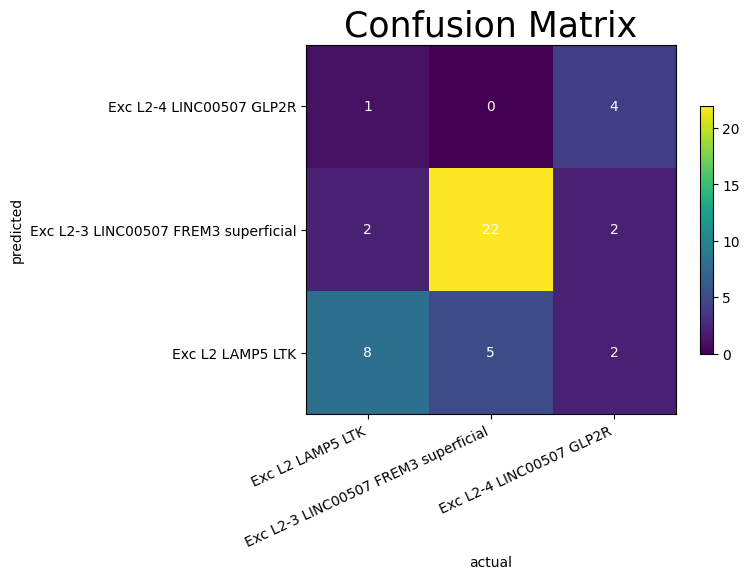

In [43]:
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(results['actual'], results['predicted'])

#imshow和matshow二者不同在于横轴一个在上方一个在下方，还有就是plt.matshow()显示图片可以连续使用，
# 但是plt.imshow()想要显示多张图片必须每次都新建一个图plt.figure()或者使用plt.subplots()
ax = plt.imshow(cfm, origin ='lower') 

plt.title("Confusion Matrix",fontsize=25)
plt.colorbar(ax.colorbar, fraction=0.025)
plt.xlabel('actual')
plt.ylabel('predicted')
# 设置刻度字体大小
plt.xticks(np.arange(len(t_types_updated)),labels=t_types_updated, rotation=25,  ha="right",fontsize=10)
plt.yticks(np.arange(len(t_types_updated)),labels=t_types_updated, fontsize=10)
#plt.set_xticklabels(t_types_updated)
for i in range(cfm.shape[0]):
    for j in range(cfm.shape[1]):
        plt.text(j, i, f'{cfm[i, j]:.0f}', ha='center', va='center', color='white')
plt.show()

## 9. 其它

### 9.1 选择特定模型预测的方法

In [44]:
# 打印模型索引和模型名
all_models = predictor.model_names()
print(all_models)

['KNeighborsUnif_BAG_L1', 'KNeighborsDist_BAG_L1', 'NeuralNetFastAI_BAG_L1', 'LightGBMXT_BAG_L1', 'LightGBM_BAG_L1', 'RandomForestGini_BAG_L1', 'RandomForestEntr_BAG_L1', 'CatBoost_BAG_L1', 'ExtraTreesGini_BAG_L1', 'ExtraTreesEntr_BAG_L1', 'XGBoost_BAG_L1', 'NeuralNetTorch_BAG_L1', 'LightGBMLarge_BAG_L1', 'CatBoost_r177_BAG_L1', 'NeuralNetTorch_r79_BAG_L1', 'LightGBM_r131_BAG_L1', 'NeuralNetFastAI_r191_BAG_L1', 'CatBoost_r9_BAG_L1', 'LightGBM_r96_BAG_L1', 'NeuralNetTorch_r22_BAG_L1', 'XGBoost_r33_BAG_L1', 'ExtraTrees_r42_BAG_L1', 'CatBoost_r137_BAG_L1', 'NeuralNetFastAI_r102_BAG_L1', 'CatBoost_r13_BAG_L1', 'RandomForest_r195_BAG_L1', 'LightGBM_r188_BAG_L1', 'NeuralNetFastAI_r145_BAG_L1', 'XGBoost_r89_BAG_L1', 'NeuralNetTorch_r30_BAG_L1', 'LightGBM_r130_BAG_L1', 'NeuralNetTorch_r86_BAG_L1', 'CatBoost_r50_BAG_L1', 'NeuralNetFastAI_r11_BAG_L1', 'XGBoost_r194_BAG_L1', 'ExtraTrees_r172_BAG_L1', 'CatBoost_r69_BAG_L1', 'NeuralNetFastAI_r103_BAG_L1', 'NeuralNetTorch_r14_BAG_L1', 'LightGBM_r161

In [45]:
# 选择特定模型预测,i为选择的模型索引
i = 0  # index of model to use
model_to_use = all_models[i]
model_pred = predictor.predict(test_data, model=model_to_use)
print("Prediction from %s model: %s" % (model_to_use, model_pred.iloc[0]))

Prediction from KNeighborsUnif_BAG_L1 model: Exc L2-3 LINC00507 FREM3 superficial


### 9.2 删除其余模型的方法

In [46]:
# 删除其余模型（减少内存开销）,只保留最佳模型
#predictor.delete_models(models_to_keep='best')

In [47]:
'''
from sklearn.preprocessing import LabelEncoder
# 转换标签列
label_encoder = LabelEncoder()
labeled_y = labeled_data[LABEL_COLUMN]
labeled_data[LABEL_COLUMN] = label_encoder.fit_transform(labeled_data[LABEL_COLUMN]).astype(np.int8)
class_dict = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print(class_dict)
'''

'\nfrom sklearn.preprocessing import LabelEncoder\n# 转换标签列\nlabel_encoder = LabelEncoder()\nlabeled_y = labeled_data[LABEL_COLUMN]\nlabeled_data[LABEL_COLUMN] = label_encoder.fit_transform(labeled_data[LABEL_COLUMN]).astype(np.int8)\nclass_dict = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))\nprint(class_dict)\n'